In [1]:
import torch
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torch.nn.functional as F
import pywt
import numpy as np
import torchvision.models as models


In [2]:


# Define the Block class with activation after each Conv2d layer
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        return x

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.block1 = Block(3, 64)
        self.block2 = Block(64, 128)
        self.block3 = Block(128, 256)
        self.block4 = Block(256, 512)
        self.block5 = Block(512, 512)
        
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 4)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Generate dummy data
# batch_size = 1
# dummy_images = torch.randn(batch_size, 3, 224, 224)  # Random images
# dummy_labels = torch.randint(0, 4, (batch_size,))  # Random labels for 4 classes

# # Number of epochs
# epochs = 10

# # List to store loss values


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
#Image load taks
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.labels_df.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
# # Load the original CSV file
# df = pd.read_csv('train/train_labels.csv')

# # Select 50 random entries
# df_sampled = df.sample(n=50)       #, random_state=42)

# # Save the new CSV file
# df_sampled.to_csv('train/sample_labels.csv', index=False)

# print("New file with 50 entries has been created.")

In [6]:

train_dataset = ImageDataset(csv_file='train/train_labels.csv', root_dir='train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)


In [7]:
# # Load the original CSV file
# df = pd.read_csv('test/test_labels.csv')

# # Select 50 random entries
# df_sampled = df.sample(n=50)      #, random_state=42)

# # Save the new CSV file
# df_sampled.to_csv('test/sample_labels.csv', index=False)

# print("New file with 50 entries has been created.")

In [8]:

test_dataset = ImageDataset(csv_file='test/test_labels.csv', root_dir='test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=4)



In [9]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = CNNModel().to(device)

In [10]:

def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss}")
        losses.append(running_loss)
        # Iterate through each named parameter (weights) in the model
    return losses

In [11]:
losses = train(model, train_dataloader, epochs=5, learning_rate=0.05, device=device)

Epoch 1/5, Loss: 7.559207437276552e+20
Epoch 2/5, Loss: 489.2448674440384
Epoch 3/5, Loss: 489.68171536922455
Epoch 4/5, Loss: 490.61091554164886
Epoch 5/5, Loss: 490.7875597476959


In [12]:
# print('Finished Training')

# # Plot the training loss
# plt.plot(losses)
# plt.xlabel('Batch Number')
# plt.ylabel('Loss')
# plt.title('Training Loss over Batches')
# plt.show()

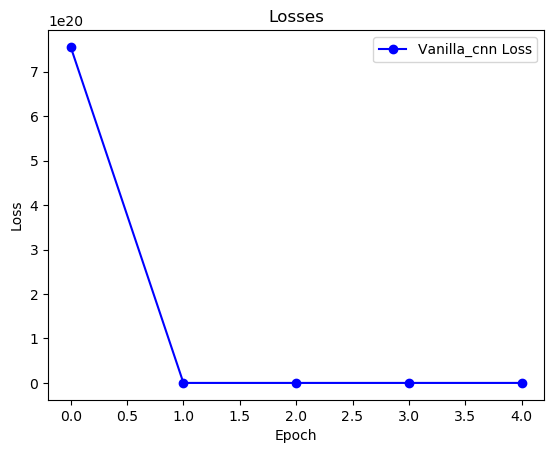

In [13]:
import matplotlib.pyplot as plt

# # Example lists of losses (replace with your actual lists)
# teacher_losses = [0.9, 0.85, 0.8, 0.78, 0.75, 0.7, 0.65, 0.63, 0.6, 0.58]
# losses_student_KD = [0.88, 0.82, 0.78, 0.74, 0.71, 0.68, 0.64, 0.61, 0.59, 0.56]

# Step 1: Plot teacher losses
plt.plot(losses, marker='o', linestyle='-', color='b', label='Vanilla_cnn Loss')


# Step 3: Add titles and labels
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Step 4: Add a legend
plt.legend()

# Step 5: Save the plot to the current folder
plt.savefig('vanilla_cnn_plot.png')

# Step 6: Show the plot (optional)
plt.show()